<a href="https://colab.research.google.com/github/DarekGit/FACES_DNN/blob/master/notebooks/05_03_FrozenBN_Mish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##<b> Batch normalization</b>
<br>Trenowanie głębokich sieci neuronowych jest skomplikowane przez fakt, że rozkład danych wejściowych każdej warstwy zmienia się podczas uczenia, gdy zmieniają się parametry poprzednich warstw. Spowalnia to traning, ponieważ wymaga niższych współczynników uczenia się i starannej inicjalizacji parametrów, sprawia również, że trudno jest trenować modele z narastającymi nieliniowościami. Nazywamy to zjawisko jako wewnętrzną zmianę współzmienną i rozwiązujemy ten problem poprzez normalizację danych wejściowych warstwy. 
<br>Batch Norm korzysta z włączania normalizacji do architektury modelu i wykonywania normalizacji dla każdej mini partii treningowej. Normalizacja wsadowa pozwala  używać znacznie wyższych współczynników uczenia się i być mniej ostrożnym podczas inicjalizacji. Działa również jako regulator, w niektórych przypadkach eliminując potrzebę stosowania Dropout. Zastosowana do najnowocześniejszego modelu klasyfikacji obrazu, Batch Norm osiąga taką samą dokładność przy 14-krotnie mniejszej liczbie kroków treningowych i znacząco poprawia oryginalne modele. 
<br>Dzięki Batch Norm, poprawiono wyniki klasyfikacji ImageNet, osigając błąd walidacji top-5 na poziomie 4.9%, przekraczając wyniki osiągane przez ludzi.

<br>Więcej informacji dostępnych jest na stronie: [arxiv.org](https://arxiv.org/pdf/1502.03167.pdf)

Serge Ioffe i Christian Szegedy w 2015 roku zaproponowali sieć z Batch Normalization (BN), w której do modelu przed aktywacją dodawana jest operacja normalizująca dane wejściowe (ustawienie średniej na zero i wariancji na jeden), a następnie zastosowanie skali i przesunięcie w celu zachowania wydajności modelu. Sieć uczy się dwóch parametrów, skalarnego (gamma) i parametru przesunięcia (Beta).
<br>

<br><div align="center">
<img alt="BN" src="https://github.com/DarekGit/FACES_DNN/blob/master/Figures/BN_mat.png?raw=1" width="420" />
</div>

<br>Domyślnie, podczas treningu BN zapamiętuje szacowaną wartość średniej i wariancji, które są następnie wykorzystywane do normalizacji. Bieżące szacunki są zapamiętywane z domyślnym momentem 0.1.

Stosowana jest metoda podobna do optymalizacji SGD, z tą różnicą, że aktualizacja odbywa się zgodnie ze wzorem:
<br>$\hat{x}_\text{new} = (1 - \text{momentum}) \times \hat{x} + \text{momentum} \times x_t$<br>
, gdzie $\hat{x}$  to wartość szacowana, a $x_t$ jest nową wartością obserwowaną .

W dokumentacji BN często podaję się, iż działanie BN oparte jest na redukcji wewnętrznego przesunięcia współzmiennego (Reducing Internal Covariate Shift). <br>Jednak przeprowadzone pomiary nie potwierdzają wprost tej relacji. Intuicyjnie opisuje się działanie BN raczej jako wyrównanie przestrzeni optymalizacji (Smoothness of the Optimization Landscape).



##<b>Frozen Batch Normalization</b>
<br>Wraz z YOLO wersja 4 wprowadzono warstwę Frozen Batch Norm, w celu przyspieszenia transfer learningu. W procesie doszkalania dla FrozenBN stosuje się stałe parametry wcześniej wytrenowane. Zaletą FrozenBN jest możliwość przełączania na BN w trakcie procesu trenowania.

In [ ]:
class FrozenBatchNorm2d(nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters are fixed.

    It contains non-trainable buffers called
    "weight" and "bias", "running_mean", "running_var",
    initialized to perform identity transformation.

    The pre-trained backbone models from Caffe2 only contain "weight" and "bias",
    which are computed from the original four parameters of BN.
    The affine transform `x * weight + bias` will perform the equivalent
    computation of `(x - running_mean) / sqrt(running_var) * weight + bias`.
    When loading a backbone model from Caffe2, "running_mean" and "running_var"
    will be left unchanged as identity transformation.

    Other pre-trained backbone models may contain all 4 parameters.

    The forward is implemented by `F.batch_norm(..., training=False)`.
    """

    _version = 3

    def __init__(self, num_features, eps=1e-5):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.register_buffer("weight", torch.ones(num_features))
        self.register_buffer("bias", torch.zeros(num_features))
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features) - eps)

    def forward(self, x):
        if x.requires_grad:
            # When gradients are needed, F.batch_norm will use extra memory
            # because its backward op computes gradients for weight/bias as well.
            scale = self.weight * (self.running_var + self.eps).rsqrt()
            bias = self.bias - self.running_mean * scale
            scale = scale.reshape(1, -1, 1, 1)
            bias = bias.reshape(1, -1, 1, 1)
            return x * scale + bias
        else:
            # When gradients are not needed, F.batch_norm is a single fused op
            # and provide more optimization opportunities.
            return F.batch_norm(
                x,
                self.running_mean,
                self.running_var,
                self.weight,
                self.bias,
                training=False,
                eps=self.eps,
            )


###Wykorzystanie FrozenBN w pracy
<br><b>W pracy wykorzystano FrozenBN w procesie doszkalania. Np. dla sieci MobilenetV2 najlepsze wyniki uzyskano dla procedury trenowania sieci z BN i doszkalania tak wytrenowanej sieci z FrozenBN.</b>
<br>Przemawia za tym inuticja, że dzieki BN można uzyskać szybsze szkolenia, jednak regularyzacja ogranicza dokładność. Przełączenie na FrozenBN w końcowej fazie szkolenia, zwiększa wariancję poprawiając ostateczne wyniki sieci.

##<br><b> Mish activation function</b><br>

Funkcja Mish jest nowatorską samoregaryzowaną niemonotoniczną funkcję aktywacji, którą można matematycznie zdefiniować jako: $ f (x) = x * tanh (softplus (x)) $. Funkcje aktywacji odgrywają kluczową rolę w wydajności i dynamice uczenia w sieciach neuronowych. Na podstawie eksperymentów stwierdzono, że Mish przewyższył Leaky ReLU na YOLOv4 ze średnią precyzją CSP-DarkNet-53 (APval50) o 2,1% w wykrywaniu obiektów MS-COCO i ReLU w ResNet-50 na ImageNet-1k pod względem dokładności Top-1 o ≈1 % przy zachowaniu stałych wszystkich innych parametrów sieci i hiperparametrów.
<br>Ponadto stwierdzono działanie Mish jako regularyzatora pomagającego w optymalizacji głębokich sieci neuronowych.

<br><b>W dalszej częsci pracy wykorzystano funkcję aktywacji Mish w sieci MobileNetV2 w Detectron2, dzięki czemu uzyskano przyspieszenie procesu uczenia oraz wynik mAP lepszy o 2pp wsględem ReLU6.</b>

<br>Pierwotnie, informacje o funkcji Mish zaczerpnięto z materiałów o [YOLO wersja 4](https://arxiv.org/abs/2004.10934).
<br> Więcej informacji o Msh dostępnych jest na stronie: [arxiv.org](https://arxiv.org/abs/1908.08681)

In [ ]:
import torch
from torch import nn
import numpy as np

class Mish(nn.Module):
    def __init__(self):
        super().__init__()
  
    def forward(self, x):
        x = x * (torch.tanh(nn.functional.softplus(x)))
        return x

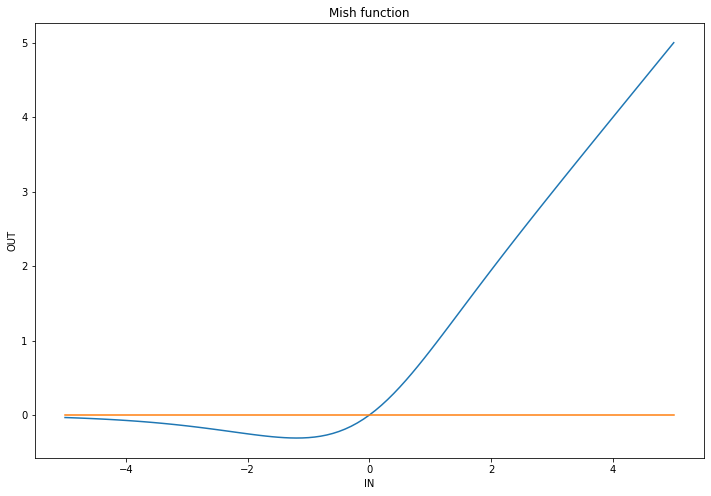

In [ ]:
mish=Mish()
x=np.arange(-5,5.1,0.1)
y,z=[],[]
for i in x:
  y.append([mish(torch.tensor([i],dtype=float)),0])
  
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(12,8))
plt.plot(x,y)
plt.title("Mish function")
plt.ylabel("OUT")
plt.xlabel("IN")
fig.savefig('Mish function.jpg')
plt.show()